# <center> Практические задания по цифровой обработке сигналов </center>
# <center> Третья лабораторная работа </center>
# <center> Фильтры </center>
В данной работе вы познакомитесь с понятием фильтра в цифровой обработке сигналов.

In [1]:
import IPython.display as ipd

import librosa
import librosa.display
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import scipy
import scipy.fft

# Disable division by zero in numpy
np.seterr(divide='raise', invalid='raise');

In [2]:
# from lab_2
def get_magnitude_from_spec(spec):
    return np.absolute(spec)


def get_phi_from_spec(spec):
    return np.angle(spec)


# Функция отрисовки аудио сигнала.
def draw_waveform(wav, sr, figsize=(14, 5)):
    # Отрисовка звукового сигнала во временной области
    plt.figure(figsize=figsize)
    librosa.display.waveplot(wav, sr=sr)
    plt.show()


# Функция отрисовки спектра
def draw_spec(spec, name=None, draw_A=True, draw_p=True, figsize=(14, 3)):
    if len(spec) < 100:
        # Рисуем точки как "леденцы на палочках"
        draw_func = plt.stem
    else:
        # При большом N "леденцы" выглядят плохо,
        # Поэтому будем рисовать огибающую функцию
        draw_func = plt.plot

    if draw_A:
        plt.figure(figsize=figsize)
        plt.title("Magnitude spectrum")
        spec_A = get_magnitude_from_spec(spec)
        draw_func(spec_A)
        plt.ylabel("Magnitude")
        plt.xlabel("n")
        if name is not None:
            plt.legend([name])
        plt.show()

    if draw_p:
        plt.figure(figsize=figsize)
        plt.title("Phase spectrum")
        phi = get_phi_from_spec(spec)
        draw_func(phi)
        plt.ylabel("Radian")
        plt.xlabel("n")
        if name is not None:
            plt.legend([name])
        plt.show()

----------------------------------------------
# Теория
[Цифровой фильтр](https://ru.wikipedia.org/wiki/Цифровой_фильтр) — любой фильтр, обрабатывающий цифровой сигнал с целью выделения и/или подавления определённых частот этого сигнала.
Цифровые фильтры применяются практическе везде, где требуется обработка цифровых сигналов (при работе со звуком, картинками, видео и так далее).

Основными характеристиками стационарных линейных дискретных фильтров являются:
* импульсная характеристика;
* переходная характеристика;
* фмплитудно-частотная характеристика;
* фазо-частотная характеристика.

**Импульсной характеристикой фильтра** называется его реакция на единичный импульс при нулевых начальных условиях.

**Переходной характеристикой фильтра** называется его реакция на воздействие в форме единичной функции.

**Амплитудно-частотной характеристикой фильтра (АЧХ)** называется зависимость амплитуды установившихся колебаний выходного сигнала от частоты её входного гармонического сигнала. Другими словами, АЧХ показывает, как фильтр влияет на амплитуду разных частот входного сигнала.

**Фазо-частотной характеристикой фильтра (ФЧХ)** называется зависимость фазы установившихся колебаний выходного сигнала от частоты её входного гармонического сигнала. Аналогична АЧХ, только показывает влияние на фазу сигнала.

В данной работе мы будем рассматривать два линейных инвариантных к сдвигу фильтра: фильтр с конечной импульсной характеристикой (КИХ-фильтр) и фильтр с бесконечной импульсной характеристикой (БИХ-фильтр).

### КИХ-фильтры
Определение с [Википедии](https://ru.wikipedia.org/wiki/%D0%A4%D0%B8%D0%BB%D1%8C%D1%82%D1%80_%D1%81_%D0%BA%D0%BE%D0%BD%D0%B5%D1%87%D0%BD%D0%BE%D0%B9_%D0%B8%D0%BC%D0%BF%D1%83%D0%BB%D1%8C%D1%81%D0%BD%D0%BE%D0%B9_%D1%85%D0%B0%D1%80%D0%B0%D0%BA%D1%82%D0%B5%D1%80%D0%B8%D1%81%D1%82%D0%B8%D0%BA%D0%BE%D0%B9):
> Фильтр с конечной импульсной характеристикой (нерекурсивный фильтр, КИХ-фильтр) или FIR-фильтр (FIR сокр. от _finite impulse response_ — конечная импульсная характеристика) — один из видов линейных цифровых фильтров, характерной особенностью которого является ограниченность по времени его импульсной характеристики (с какого-то момента времени она становится точно равной нулю). Такой фильтр называют ещё нерекурсивным из-за отсутствия обратной связи. Знаменатель передаточной функции такого фильтра — константа.

![resources/fir.png](resources/fir.png)

### БИХ-фильтры
Определение с [Википедии](https://ru.wikipedia.org/wiki/%D0%A4%D0%B8%D0%BB%D1%8C%D1%82%D1%80_%D1%81_%D0%B1%D0%B5%D1%81%D0%BA%D0%BE%D0%BD%D0%B5%D1%87%D0%BD%D0%BE%D0%B9_%D0%B8%D0%BC%D0%BF%D1%83%D0%BB%D1%8C%D1%81%D0%BD%D0%BE%D0%B9_%D1%85%D0%B0%D1%80%D0%B0%D0%BA%D1%82%D0%B5%D1%80%D0%B8%D1%81%D1%82%D0%B8%D0%BA%D0%BE%D0%B9):
> Фильтр с бесконечной импульсной характеристикой (рекурсивный фильтр, БИХ-фильтр) или IIR-фильтр (IIR сокр. от _infinite impulse response_ — бесконечная импульсная характеристика) — линейный электронный фильтр, использующий один или более своих выходов в качестве входа, то есть образующий обратную связь. Основным свойством таких фильтров является то, что их импульсная переходная характеристика имеет бесконечную длину во временной области, а передаточная функция имеет дробно-рациональный вид. Такие фильтры могут быть как аналоговыми, так и цифровыми.

![resources/iir.png](resources/iir.png)

----------------------------

## Задание 1 (2 балла)
Реализуйте КИХ-фильтр и БИХ-фильтр.

In [3]:
# Определяем фильтры
def FIR_filter(x, alpha_prev=0.5, alpha_curr=0.5):
    # alpha_prev - weight for previous frame
    # alpha_curr - weight for current frame
    y = np.zeros_like(x)
    y[0] = alpha_curr * x[0]
    for i in range(1, len(x)):
        y[i] = alpha_curr * x[i] + alpha_prev * x[i - 1]
    return y


def IIR_filter(x, alpha=0.5):
    # alpha - weight for reccurent connection
    y = np.zeros_like(x)
    y[0] = x[0]
    for i in range(1, len(x)):
        y[i] = x[i] + alpha * y[i - 1]
    return y

In [4]:
def test_filters():
    x = np.ones(10)
    y = FIR_filter(x)
    assert y[0] == 0.5 and (y[1:] == 1).all(), \
        f"Bad FIR. x={x}, y={y}."
    y = FIR_filter(x, alpha_prev=0.1, alpha_curr=0.9)
    assert y[0] == 0.9 and (y[1:] == 1).all(), \
        f"Bad FIR (alphas 0.1 and 0.9). x={x}, y={y}."
    y = IIR_filter(x)
    assert y[0] == 1 and (y[3:].round() == 2).all() and (y < 2).all(), \
        f"Bad IIR. x={x}, y={y}."
    y = IIR_filter(x, 0.2)
    assert y[0] == 1 and (y[3:].round(2) == 1.25).all() and (y < 1.25).all(), \
        f"Bad IIR (alpha=0.2). x={x}, y={y}."
    print("All OK!")

test_filters()

All OK!


# Импульсная и переходная характеристики

## Задание 2 (1 балл)

Определите единичный импульс длиной 20 отсчётов (переменная `impulse`).

Получите импульсную характеристику фильтров.

In [5]:
def draw_impulse_response(signal, signal_response, title, signal_name,
                          ymin, ymax):
    plt.figure(figsize=(12, 3))
    plt.title(title)
    plt.grid(True)
    plt.plot(signal, 'o-')
    plt.plot(signal_response, '.-')
    plt.legend([signal_name, 'Фильтр'])
    plt.axis([-0.1, len(signal), ymin, ymax])
    plt.show()

Импульсная характеристика фильтров с alpha=0.5:


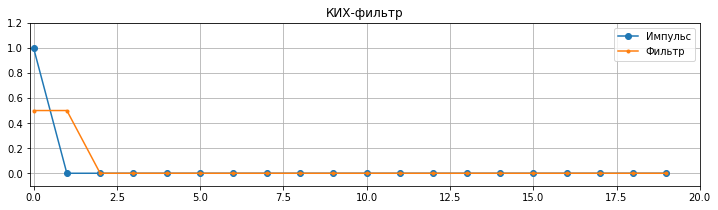

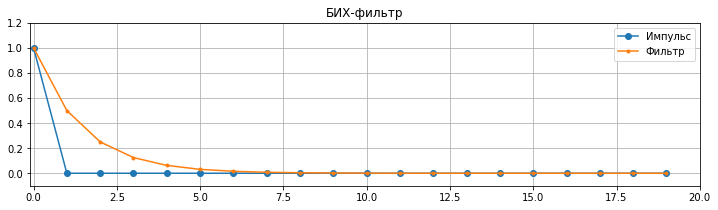

In [6]:
print("Импульсная характеристика фильтров с alpha=0.5:")

# Получите импульсную характеристику FIR_filter и IIR_filter
impulse = np.zeros(20)
impulse[0] = 1
fir_impulse_response = FIR_filter(impulse)
iir_impulse_response = IIR_filter(impulse)

draw_impulse_response(impulse, fir_impulse_response,
                      "КИХ-фильтр", "Импульс",
                      -0.1, 1.2)
draw_impulse_response(impulse, iir_impulse_response,
                      "БИХ-фильтр", "Импульс",
                      -0.1, 1.2)

In [7]:
assert impulse.shape[0] == 20, "Bad impulse shape."
assert (fir_impulse_response[0:2] == 0.5).all() and \
       (fir_impulse_response[2:] == 0).all(), "Bad FIR."
assert iir_impulse_response.sum().round() == 2 and \
       iir_impulse_response.sum() < 2 and \
       (iir_impulse_response != 0).all(), "Bad IIR."
assert iir_impulse_response[1:].sum().round() == 1 and \
       iir_impulse_response[1:].sum() < 1 and \
       iir_impulse_response[2:].sum() < 0.5, "Bad IIR."
print("All OK!")

All OK!


## Задание 3 (1 балл)

Определите единичный скачок длиной 20 отсчётов (переменная `step`).

Получите переходную характеристику фильтров.

Переходная характеристика фильтров с alpha=0.5:


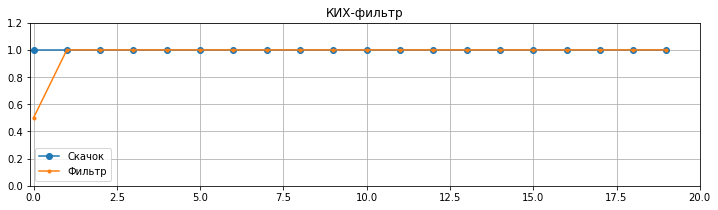

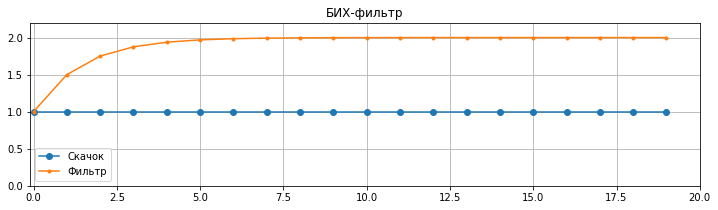

In [8]:
print("Переходная характеристика фильтров с alpha=0.5:")

# Получите переходную характеристику фильтров
step = np.ones(20)
fir_step_response = FIR_filter(step)
iir_step_response = IIR_filter(step)

draw_impulse_response(step, fir_step_response,
                      "КИХ-фильтр", "Скачок",
                      0, 1.2)
draw_impulse_response(step, iir_step_response,
                      "БИХ-фильтр", "Скачок",
                      0, 2.2)

In [9]:
assert step.shape[0] == 20, "Bad step shape."
assert fir_step_response[0] == 0.5 and \
        (fir_step_response[1:] == 1).all(), "Bad FIR."
assert iir_step_response[0] == 1 and \
       iir_step_response[1] == 1.5 and \
       iir_step_response[2] == 1.75 and \
       iir_step_response.mean().round() == 2 and \
       (iir_step_response < 2).all(), "Bad IIR."
print("All OK!")

All OK!


# Амплитудно-частотная и фазо-частотная характеристики

## Задание 4 (1 балл)

Получите амплитудно-частотную характеристику фильтров.

Амплитудно-частотная характеристика фильтров с alpha=0.5:


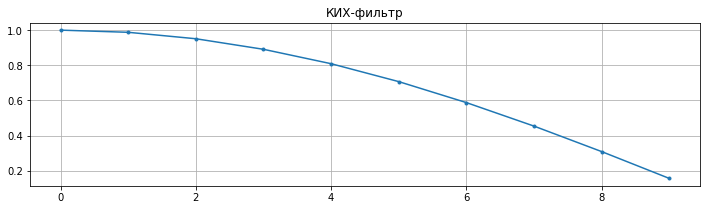

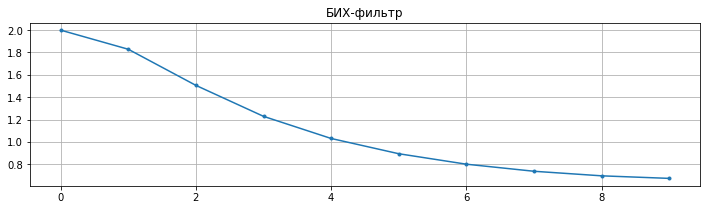

In [10]:
print("Амплитудно-частотная характеристика фильтров с alpha=0.5:")

# Получить амплитудно-частотную характеристику
fir_frequency_response = np.absolute(scipy.fft.fft(FIR_filter(impulse)))[:10]
iir_frequency_response = np.absolute(scipy.fft.fft(IIR_filter(impulse)))[:10]

plt.figure(figsize=(12, 3))
plt.grid(True)
plt.title("КИХ-фильтр")
plt.plot(fir_frequency_response, '.-')
plt.show()

plt.figure(figsize=(12, 3))
plt.grid(True)
plt.title("БИХ-фильтр")
plt.plot(iir_frequency_response, '.-')
plt.show()

In [11]:
assert fir_frequency_response.shape[0] == \
       iir_frequency_response.shape[0] == 10, \
       f"Bad FR shape. Must be N // 2."
_ideal_fir_fr = np.array([1., 0.98768834, 0.95105652, 0.89100652,
                          0.80901699, 0.70710678, 0.58778525,
                          0.4539905, 0.30901699, 0.15643447])
assert np.allclose(fir_frequency_response, _ideal_fir_fr), \
    f"Bad FIR FR. " \
    f"Diff is {np.abs(fir_frequency_response - _ideal_fir_fr).sum()}."
_ideal_iir_fr = np.array([1.99999809, 1.82896351, 1.50587408,
                          1.22885364, 1.03088138, 0.89442634,
                          0.80089238, 0.73765316, 0.69689865, 0.67403739])
assert np.allclose(iir_frequency_response, _ideal_iir_fr), \
    f"Bad IIR FR. " \
    f"Diff is {np.abs(iir_frequency_response - _ideal_iir_fr).sum()}."

print("All OK!")

All OK!


## Задание 5 (1 балл)

Получите фазо-частотную характеристику фильтров.

Фазо-частотная характеристика:


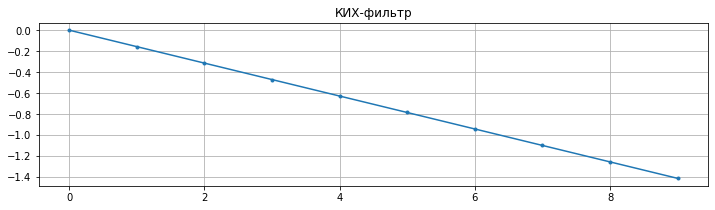

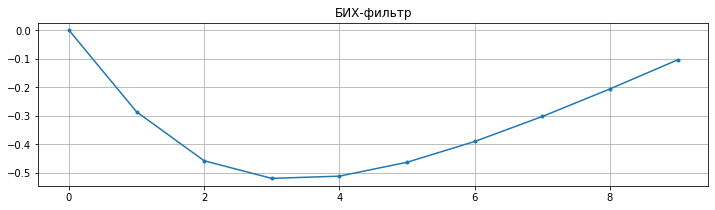

In [12]:
print("Фазо-частотная характеристика:")

# Получить фазо-частотную характеристику
fir_phase_response = np.angle(scipy.fft.fft(FIR_filter(impulse)))[:10]
iir_phase_response = np.angle(scipy.fft.fft(IIR_filter(impulse)))[:10]

plt.figure(figsize=(12, 3))
plt.grid(True)
plt.title("КИХ-фильтр")
plt.plot(fir_phase_response, '.-')
plt.show()

plt.figure(figsize=(12, 3))
plt.grid(True)
plt.title("БИХ-фильтр")
plt.plot(iir_phase_response, '.-')

plt.show()

In [13]:
assert fir_phase_response.shape[0] == iir_phase_response.shape[0] == 10, \
    f"Bad PR shape. Must be N // 2."
_ideal_fir_pr = np.array([-0., -0.15707963, -0.31415927, -0.4712389,
                          -0.62831853, -0.78539816, -0.9424778 ,
                          -1.09955743, -1.25663706, -1.41371669])
assert np.allclose(fir_phase_response, _ideal_fir_pr), \
    f"Bad FIR PR. Diff is {np.abs(fir_phase_response - _ideal_fir_pr).sum()}."
_ideal_iir_pr = np.array([-0., -0.28649379, -0.45845783, -0.52023287,
                          -0.51233491, -0.46364761, -0.39071251,
                          -0.30300249, -0.20627323, -0.10433379])
assert np.allclose(iir_phase_response, _ideal_iir_pr), \
    f"Bad IIR PR. Diff is {np.abs(iir_phase_response - _ideal_iir_pr).sum()}."

print("All OK!")

All OK!
